In [1]:
# Make sure we are in the `deep-radar` directory.
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
print("cwd:", os.getcwd())

cwd: /home/tianshu/Documents/RadarML/deep-radar


In [2]:
import numpy as np

import analysis


def comparison_grid(
    axs: np.ndarray, compare: dict[str, analysis.ComparativeStats],
    method_names: list[str] = []
) -> None:
    """Plot grid of comparison plots."""
    for row, (category, stats) in zip(axs, compare.items()):
        stats = stats.sum()
        pct = stats.percent()
        analysis.comparison_matrix(
            row[0], np.sign(pct) * np.sqrt(np.abs(pct)), label=pct,
            unit="%", cmap='coolwarm', centered=True)
        analysis.comparison_matrix(
            row[1],
            stats.significance(p=0.05, corrected=True, subgroups=len(compare))
            + stats.significance(p=0.05, corrected=False),
            label=stats.diff.zscore, unit=" se", cmap='coolwarm',
            vmin=-2.3, vmax=2.3)

    for ax, category in zip(axs[:, 0], compare):
        ax.set_ylabel(category)
        ax.set_yticklabels(method_names)
    for ax in axs[:, 1:].reshape(-1):
        ax.set_yticks([])

    metric_names = [
        "percent difference", "z-score",
        "effective sample size", "standard error"]
    for ax, metric in zip(axs[-1], metric_names):
        ax.set_xlabel(metric)
        ax.set_xticklabels(method_names, rotation=90)
    for ax in axs[:-1].reshape(-1):
        ax.set_xticks([])

In [5]:
results = analysis.Results("results")
methods = [
    "unet/b.i", "unet/b.i.noaug",
    "unet/b.o", "unet/b.o.noaug",
    "unet/b.io", "unet/b.io.noaug"]
method_names = [
    "unet/indoor+aug", "unet/indoor",
    "unet/outdoor+aug", "unet/outdoor",
    "unet/joint+aug", "unet/joint"]
metric = "bev_loss"
compare = {
    "indoor": results.compare(methods, key=metric, pattern="^indoor"),
    "outdoor": results.compare(methods, key=metric, pattern="^outdoor")
}

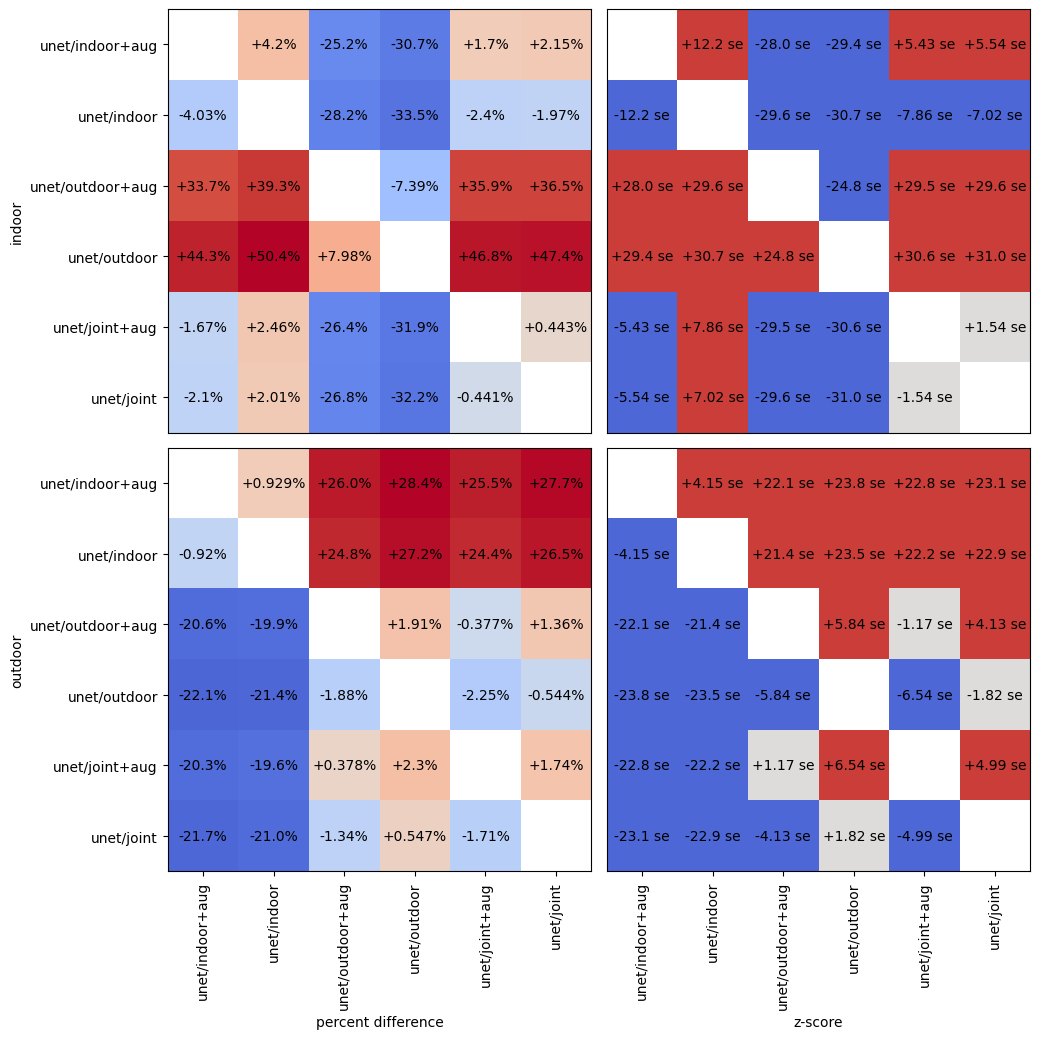

In [6]:
from matplotlib import pyplot as plt

size = 0.75 * len(methods)
fig, axs = plt.subplots(
    len(compare), 2, figsize=(1.5 + size * 2, 1.5 + size * len(compare)))
comparison_grid(axs, compare, method_names)
fig.tight_layout()
fig.savefig("notebooks/compare.pdf")